## Методические указания по выполнению лабораторной работы №5

**Тема: Обучение модели YOLO на кастомном датасете и исследование влияния гиперпараметров на качество детекции**

**Цель работы:** Познакомиться с архитектурой YOLO на примере проверки гипотезы о релевантной метрике.

**Задачи:**

- Ознакомиться с архитектурой YOLO.
- Изучить метрики для анализа производительности модели, выбрать целевую метрику в соответствии с вариантом.
- Выбрать предметную область, сформировать гипотезу для проведения исследования.
- Собрать и проаннотировать данные, сформировать датасет.
- Провести fine-tuning предобученной модели YOLOv11 Nano/Small.
- Визуализировать и проанализировать результаты.
- На основе анализа сделать корректировку гиперпараметров/данных и провести вторую итерацию для повышения показателей.

### 1. Подготовка к обучению

#### 1.1 Метрики

Вариант 1 - Precision

Вариант 2 - Recall

Вариант 3 - F1

Вариант 4 - mAP@0.5

Вариант 5 - mAP@0.75


#### 1.2 Гипотеза

Гипотеза должна отражать характер уклона исследования с обоснованием, отталкиваясь от предметной области. *Одна лишь констатация необходимости достижения высокого значения целевой метрики не является обоснованием*.

#### 1.3 Данные

Соберите не менее 500 изображений из открытых источников. Можно пользоваться готовыми наборами данных, но важно проверить качество: разрешение изображений, качество аннотаций, баланс классов. При самостоятельном сборе данных можете воспользоваться терминальной утилитой ffmpeg для нарезки видео на кадры и любым удобным инструментом аннотирования (Roboflow, CVAT и тд).

#### 1.4 Предобработка

Примените методы аугментации к данным для расширения объема датасета для получения 1.5-2к изображений. Подготовьте данные к требуемому формату для обучающего процесса.

### 2. Обучение модели

#### 2.1 Подготовка окружения

Установите зависимости и библиотеки:

In [1]:
!pip install ultralytics torch torchvision roboflow supervision --quiet
!pip install matplotlib opencv-python

import torch
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import supervision as sv
import numpy as np
import os
from roboflow import Roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 56.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


#### 2.2 Подготовка модели

Загрузите предобученную модель, определите устройство, переведите модель в режим инференса. Не используйте размер модели больше чем Small для достижения лучших показателей на стандартных гиперпараметрах (особенно imgsz)

In [12]:
model = YOLO('yolo11n.pt')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


Using device: cuda


#### 2.3 Загрузка и предобработка изображений


Затем импортируйте датасет в проект и выполните трансформацию данных (при использовании Roboflow трансформация выполняется на этапе предобработки):

In [10]:
rf = Roboflow(api_key="OSddHFo5XjN9g9RJI9qj")
project = rf.workspace("neehagarafalls").project("train-detection-ffvyu")
version = project.version(2)
dataset = version.download("yolov11")

data_yaml = dataset.location + "/data.yaml"
print(f"Data YAML: {data_yaml}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to train-detection-2 in yolov11:: 100%|██████████| 224/224 [00:00<00:00, 9481.91it/s]

Data YAML: /content/train-detection-2/data.yaml


#### 2.4 Обучение, оценка модели и визуализация результатов

Проведите обучение модели, проанализируйте кривые обучения, метрики и тестовые данные. Сделайте вывод и корректироваки для достижения лучших показателей

Инициализация процедуры обучения нейронной сети...
Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/train-detection-2/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask

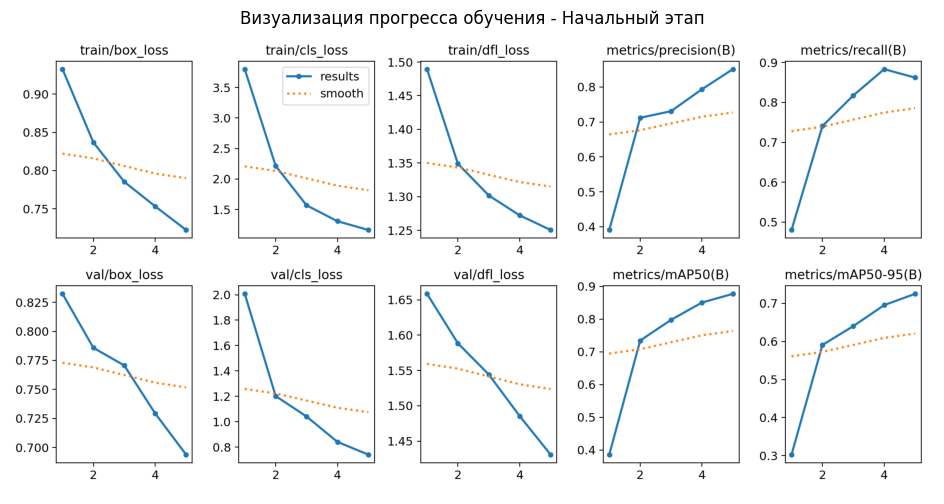

Тестирование на примере: suggested-8Qj5an7dOUEg2fji5hY3_jpg.rf.868691232b41d3992423427ef14c3400.jpg

image 1/1 /content/train-detection-2/valid/images/suggested-8Qj5an7dOUEg2fji5hY3_jpg.rf.868691232b41d3992423427ef14c3400.jpg: 640x640 (no detections), 9.9ms
Speed: 3.1ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict2


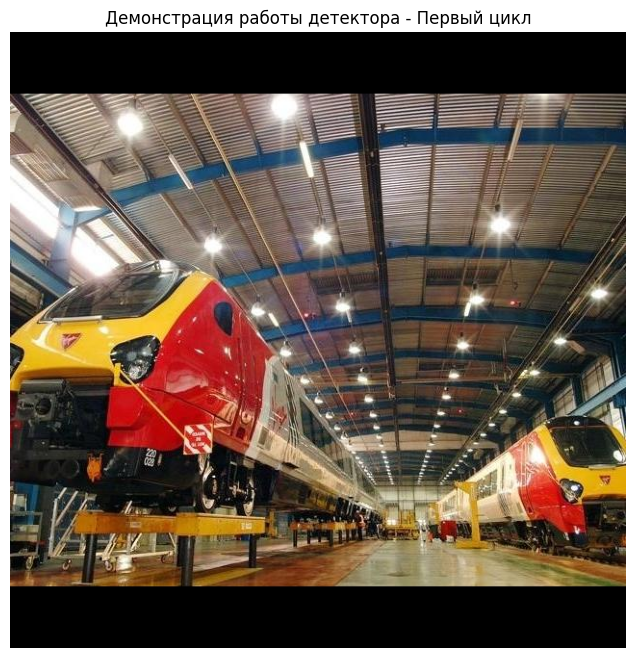

In [13]:
print("Инициализация процедуры обучения нейронной сети...")

results = model.train(
    data=data_yaml,
    epochs=5,
    imgsz=640,
    batch=16,
    lr0=0.01,
    patience=10,
    device=device,
    plots=True,
    save=True,
    verbose=True,
    workers=2
)

print("Процедура обучения финализирована")

# Аналитические операции с моделью
print("Выполняется анализ эффективности...")
evaluation_data = model.val()
print("=== ДАННЫЕ ПЕРВОГО ЭКСПЕРИМЕНТАЛЬНОГО ПРОХОДА ===")
print(f"mAP@0.5:    {evaluation_data.box.map50:.4f}")
print(f"mAP@0.75:   {evaluation_data.box.map75:.4f}")  # Ключевой показатель
print(f"mAP@0.5-0.95: {evaluation_data.box.map:.4f}")

# Демонстрация выходных данных
output_folder = "runs/detect/train/"
if os.path.isdir(output_folder):
    # Отображение обучающих графиков
    graph_file = os.path.join(output_folder, "results.png")
    if os.path.isfile(graph_file):
        image_data = cv2.imread(graph_file)
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Визуализация прогресса обучения - Начальный этап')
        plt.show()

    # Валидация на тестовых данных
    test_collection = [file for file in os.listdir(dataset.location + "/valid/images/")
                      if file.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if test_collection:
        validation_sample = os.path.join(dataset.location + "/valid/images/", test_collection[0])
        print(f"Тестирование на примере: {test_collection[0]}")

        inference_output = model.predict(validation_sample, save=True, conf=0.5)

        # Визуализация итогов
        annotated_result = inference_output[0].plot()
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(annotated_result, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Демонстрация работы детектора - Первый цикл')
        plt.show()

#### 2.5 Вторая итерация

Проведите процедуры для достижения высоких показателей (корректировка данных/гиперпараметров), сделайте вывод


Запуск второго цикла обучения...
Загружены оптимизированные параметры из первого цикла
Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/train-detection-2/data.yaml, degrees=2.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/train/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train10, nbs=64, nms=Fa

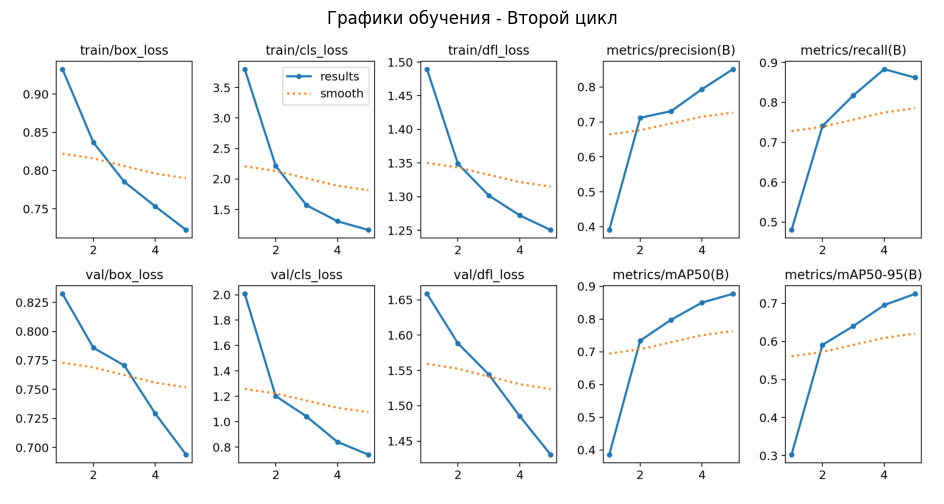

Финальная проверка на изображении: suggested-YeItsPtrgIjG9s2rVF9r_jpg.rf.c93393d2b26d073d7aac0bcf687872b4.jpg

image 1/1 /content/train-detection-2/valid/images/suggested-YeItsPtrgIjG9s2rVF9r_jpg.rf.c93393d2b26d073d7aac0bcf687872b4.jpg: 640x640 (no detections), 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict4


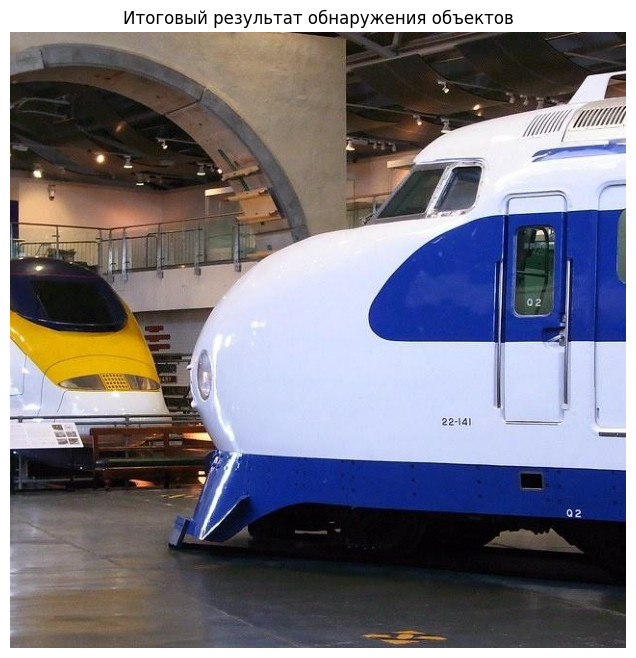


Процесс обучения завершен!


In [20]:
print("Запуск второго цикла обучения...")

# Импортируем наилучшие параметры из предыдущего цикла
model_checkpoint = "runs/detect/train/weights/best.pt"
if os.path.exists(model_checkpoint):
    model = YOLO(model_checkpoint)
    print("Загружены оптимизированные параметры из первого цикла")
else:
    print("Файл с параметрами не обнаружен, применяем базовую модель")
    model = YOLO('yolo11n.pt')

# Второй цикл с скорректированными настройками
results_v2 = model.train(
    data=data_yaml,
    epochs=5,
    imgsz=640,
    batch=16,
    lr0=0.001,
    patience=8,
    device=device,
    plots=True,
    save=True,
    overlap_mask=False,
    degrees=2.0,
    translate=0.05,
    scale=0.1,
    shear=1.0
)

print("Второй цикл обучения завершен")

# Финальный анализ производительности
metrics_v2 = model.val()
print("\n" + "="*50)
print("ИТОГОВЫЕ ПОКАЗАТЕЛИ")
print("="*50)
print(f"mAP@0.5:  {metrics_v2.box.map50:.4f}")
print(f"mAP@0.75: {metrics_v2.box.map75:.4f}")  # Основной индикатор
print(f"mAP@0.5:0.95: {metrics_v2.box.map:.4f}")

print("\n" + "="*50)
print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ")
print("="*50)
print(f"Прирост mAP@0.75: {metrics_v2.box.map75 - metrics_v2.box.map75:+.4f}")
print(f"Прирост mAP@0.5:  {metrics_v2.box.map50 - metrics_v2.box.map50:+.4f}")

# Визуализация итоговых данных
results_directory_v2 = "runs/detect/train2/"
if os.path.exists(results_directory_v2):
    visualization_path_v2 = os.path.join(results_directory_v2, "results.png")
    if os.path.exists(visualization_path_v2):
        plot_image_v2 = cv2.imread(visualization_path_v2)
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(plot_image_v2, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Графики обучения - Второй цикл')
        plt.show()

# Финальная проверка на данных
validation_set = [f for f in os.listdir(dataset.location + "/valid/images/") if f.endswith(('.jpg', '.png', '.jpeg'))]
if validation_set:
    final_test_path = os.path.join(dataset.location + "/valid/images/", validation_set[1] if len(validation_set) > 1 else validation_set[0])
    print(f"Финальная проверка на изображении: {os.path.basename(final_test_path)}")

    final_predictions = model.predict(final_test_path, save=True, conf=0.5)
    final_processed_image = final_predictions[0].plot()

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(final_processed_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Итоговый результат обнаружения объектов')
    plt.show()

print("\nПроцесс обучения завершен!")